In [5]:
# Importing Libraries

#Plotting 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import matplotlib.lines as mlines
import seaborn as sns

#pandas and numpy dataframe manipulation 
import pandas as pd
import numpy as np

#datetime modules for sampling times 
from datetime import datetime
from datetime import timedelta

#scikit learn modules for modelling 
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler, 
    Normalizer)
from sklearn.cross_decomposition import PLSRegression
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_predict

#scipy modules for statistics, spectra normalisation, ALS baseline estimation 
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.linalg import cholesky
from scipy.stats import norm
from scipy.sparse.linalg import spsolve

## Raman
- What is Raman Spectroscopy?
- What is the data here? 
- What is chemometrics? 
    - Maybe the above discussion will go in the Readme instead? 
1. **Read in the data**
    - Two csv files from the Raman. 
    - Reference spectra: How collected? This is our training set? 
    - Experimental spectra: This will be what we are trying to find out. 
2. **Plot the data**
    - Before doing anything, plot all the available data to get a visual overview of the spectra that were read in. 
3. **Preprocessing**
    - Area of the spectra of interest is 300 - 2000 cm<sup>-1</sup>, as the rest is just noisy data
    - Choose a scaler/ Normalization technique 
    - 1<sup>st</sup>  derivative
    - Identify peak
    - Baseline 
4. **Modelling**
    - PLS model


In [30]:
################ Read in the Data ##########################
reference_raman_spectra= pd.read_csv("./data/Raw Raman Data - Reference.csv", index_col=0)
reference_raman_spectra.columns.name="Concentration IgG 1 (mg/mL)"

experimental_raman_spectra= pd.read_csv("./data/Raw Raman Data - Experiment.csv").T #csv of experimental data must be transposed
experimental_raman_spectra.columns=experimental_raman_spectra.iloc[0] #Set the first row as the column header.
experimental_raman_spectra.drop(index=experimental_raman_spectra.index[0], inplace=True) #Drop the first row
experimental_raman_spectra.index=pd.Index(experimental_raman_spectra.index.astype(int), dtype='int64', name='RamanShift') 
sampling_time = [timedelta(minutes=minutes) for minutes in experimental_raman_spectra.columns]
sampling_time_formatted = [f"{(time.seconds//60):02}:{(time.seconds%60):02}" for time in sampling_time]
experimental_raman_spectra.columns=sampling_time_formatted
experimental_raman_spectra.columns.name="Sampling Time (MM:SS)"

In [ ]:
# Define the variables that will be used in this script: 
wavenumbers = np.sort(np.array(experimental_raman_spectra.index, dtype=int)) #Need to sort the wavenumbers for the x-axis
purple_colors = cm.viridis(np.linspace(0, 1, len(reference_raman_spectra.columns))) #Generate a shorter colourmap of the viridis colours to cycle through. 
red_colors = cm.seismic(np.linspace(0, 1, len(experimental_raman_spectra.columns)))

(None, None)

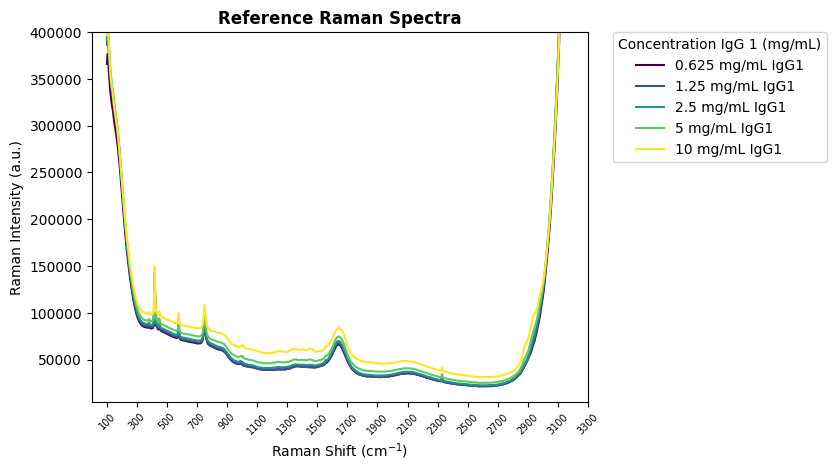

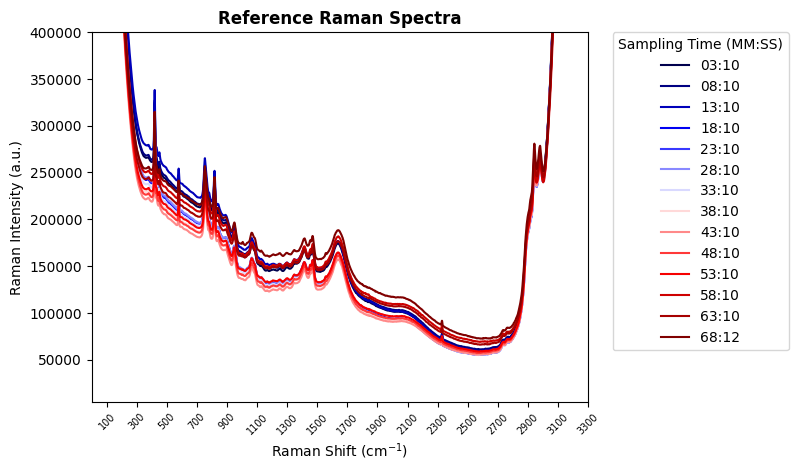

In [43]:
#Define the plotting functions
###############################  1. Overview of the Data  ###################################  
def plot_raw_spectra(dataframe, colorscheme):
        fig, ax = plt.subplots()
        for i, column in enumerate(dataframe.columns):
            ax.plot(
                dataframe.index,
                dataframe[column],
                label=column,
                color=colorscheme[i]
            )
        ax.set_xticks(wavenumbers[::200])
        ax.set_xticklabels(wavenumbers[::200], rotation=45, 
                        fontdict= {'fontsize': 'x-small',}
                        )
        ax.set_xlim(0,3300)
        ax.set_ylim(5000,0.4e6)
        ax.set_xlabel(r'Raman Shift (cm$^{-1})$')
        ax.set_ylabel("Raman Intensity (a.u.)")
        ax.set_title("Reference Raman Spectra",
                    fontdict = {'fontsize': 'large','fontweight' : "bold",}
                    )
        ax.legend(title= dataframe.columns.name,
          loc="upper left",
          bbox_to_anchor=(1.05, 1),
          borderaxespad=0
          )
plot_raw_spectra(reference_raman_spectra, purple_colors), plot_raw_spectra(experimental_raman_spectra, red_colors)

## Generating the legend
For many applications, a perceptually uniform colormap is the best choice; i.e. a colormap in which equal steps in data are perceived as equal steps in the color space. Researchers have found that the human brain perceives changes in the lightness parameter as changes in the data much better than, for example, changes in hue. Therefore, colormaps which have monotonically increasing lightness through the colormap will be better interpreted by the viewer
References: 
- [Reference for how to choose appropriate colour maps](https://matplotlib.org/stable/users/explain/colors/colormaps.html#sphx-glr-users-explain-colors-colormaps-py) 
- [Reference for the colourmaps available](https://matplotlib.org/stable/gallery/color/colormap_reference.html) 
- [Reference for fixing the scale on the matplolib colour maps](https://matplotlib.org/stable/users/explain/colors/colorbar_only.html)
- [Reference for fixing the legend through creating proxy artists](https://matplotlib.org/stable/users/explain/axes/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists)
- [Controlling the legend entries](https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries)
- [Adding multiple legends to same axis](https://matplotlib.org/stable/users/explain/axes/legend_guide.html#multiple-legends-on-the-same-axes)
- [Chapter on Python for Datascience legend formatting](https://jakevdp.github.io/PythonDataScienceHandbook/04.06-customizing-legends.html#Multiple-Legends)


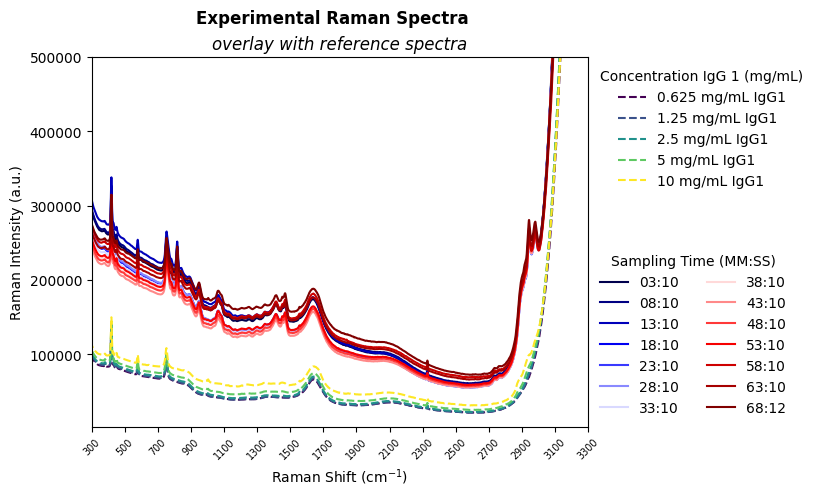

In [68]:
def plot_overlaid_spectra(dataframe_1, colorscheme_1, dataframe_2, colorscheme_2):
        fig,ax=plt.subplots()
        for i, column in enumerate(dataframe_1.columns):
            ax.plot(
                dataframe_1.index,
                dataframe_1[column],
                label=column,
                color=colorscheme_1[i],
                linestyle="--"
            )
        for i, column in enumerate(dataframe_2):
            ax.plot(
                dataframe_2.index,
                dataframe_2[column],
                label=column,
                color=colorscheme_2[i]
            )
        ax.set_xticks(wavenumbers[::200])
        ax.set_xticklabels(wavenumbers[::200], rotation=45, 
                        fontdict= {'fontsize': 'x-small',}
                        )
        ax.set_xlim(300,3300)
        ax.set_ylim(2500,0.5e6)
        ax.set_xlabel(r'Raman Shift (cm$^{-1})$')
        ax.set_ylabel("Raman Intensity (a.u.)")
        ax.set_title(f"overlay with reference spectra",
                    fontdict = {'fontsize': 'large','fontstyle' : "italic",}
                    )
        fig.suptitle(f"Experimental Raman Spectra",
                    fontweight="bold"
                    )
        #Generate the legends: 
        handles, labels = ax.get_legend_handles_labels()
        legend_2= ax.legend(handles[len(dataframe_1.columns):], 
                            labels[len(dataframe_1.columns):],
                            title=dataframe_2.columns.name,
                            ncols=2,
                            loc="upper left",
                            bbox_to_anchor=(1, 0.5),
                            frameon=False
                            )
        ax.add_artist(legend_2)
        ax.legend(handles[0:len(dataframe_1.columns)], 
                  labels[0:len(dataframe_1.columns)],
                  title=dataframe_1.columns.name,
                  loc="upper left",
                  bbox_to_anchor=(1, 1),
                  frameon=False
                )
        
plot_overlaid_spectra(reference_raman_spectra, purple_colors, experimental_raman_spectra, red_colors)

## Compute the 1st Derivative:
- Using Savistk Golay in Scipy 
- https://towardsdatascience.com/data-science-for-raman-spectroscopy-a-practical-example-e81c56cf25f



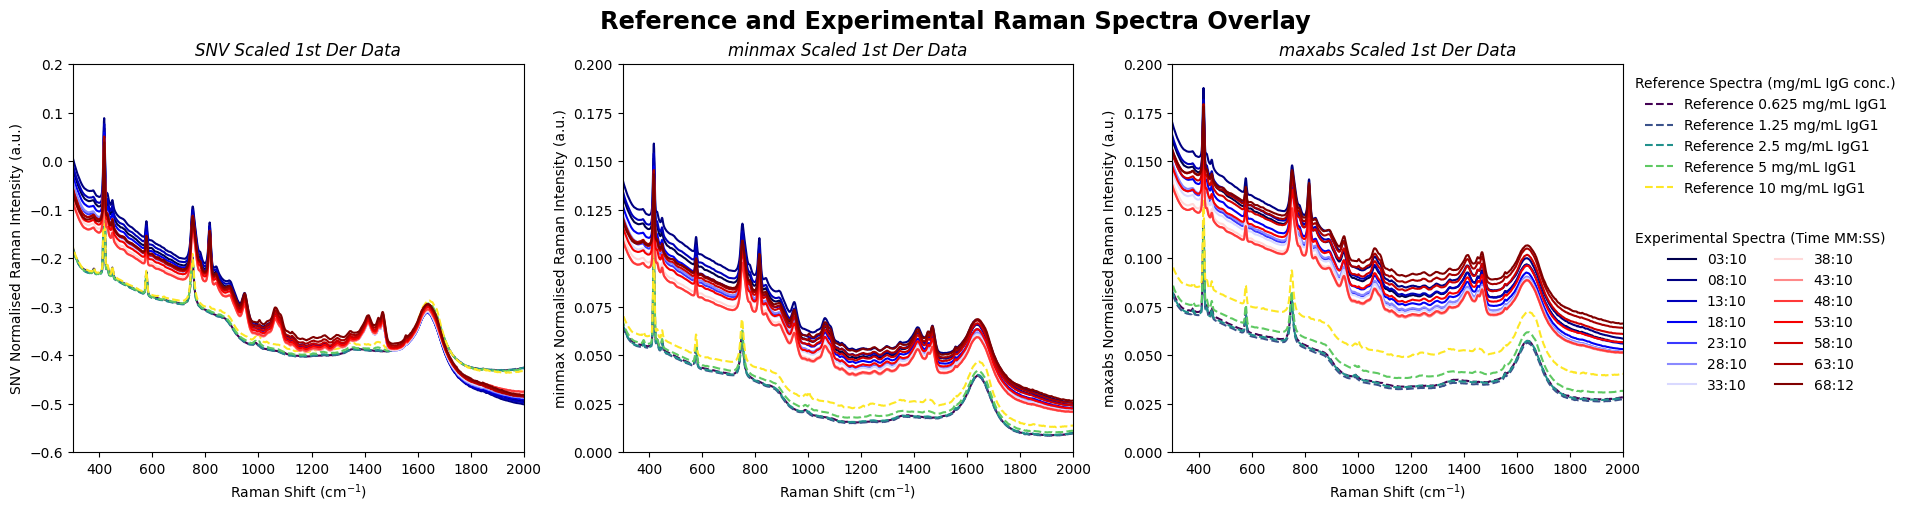

In [ ]:
scaled_data = {} #initialise an empty dictionary to save the scaled data to

def normalised_first_derivative(dataframe, scaler):
    # Compute the first derivative using the Savitzky-Golay filter
    first_der = savgol_filter(np.array(dataframe), window_length=5, delta=dataframe.index[1] - dataframe.index[0], polyorder=3)

    # Apply the scaling to the first derivative
    scaled_spectra = scaler.fit_transform(first_der)  # Reshape to 2D to avoid errors with this function
    return scaled_spectra

# Iterate over scalers and spectra to populate the scaled_data dictionary
for scaler, scaler_name in zip([preprocessing.StandardScaler(), preprocessing.MinMaxScaler(), preprocessing.MaxAbsScaler()], ["SNV", "minmax", "maxabs"]):
    for spectra, spectra_name in zip([reference_raman_spectra, experimental_raman_spectra], ['reference', 'experimental']):
        # Call normalised_first_derivative to get the scaled spectra
        scaled_spectra = normalised_first_derivative(spectra, scaler)
        key_name = f"{scaler_name}_scaled_{spectra_name}_spectra" #Create a dictionary key that reflects the scaler and spectra and store the scaled spectra in the dictionary with the appropriate key
        scaled_data[key_name] = scaled_spectra


#Plot the different normalisation techniques
def plot_normalisation_techniques():
    fig,ax=plt.subplots(1, 3, figsize=(19, 5), layout = "constrained")

    for i, scaler in enumerate(["SNV", "minmax", "maxabs"]):
        reference_data_scaled = scaled_data[f"{scaler}_scaled_reference_spectra"]
        reference_data_scaled = pd.DataFrame(
            data= scaled_data[f"{scaler}_scaled_reference_spectra"],
            index=reference_raman_spectra.index,
            columns=reference_raman_spectra.columns
        )
        experimental_data_scaled = pd.DataFrame(
            data= scaled_data[f"{scaler}_scaled_experimental_spectra"],
            index=experimental_raman_spectra.index,
            columns=experimental_raman_spectra.columns
        )
        #Plot the reference spectra:
        for j, column in enumerate(reference_data_scaled): #Gives each Column an index id to call for the list of colours I want to use
            ax[i].plot(
                reference_raman_spectra.index,
                reference_data_scaled[column],
                linestyle="--",
                color=purple_colors[j],
                label=f"Reference {column}")
        #Plot the experimental data: 
        for j, column in enumerate(experimental_data_scaled):
            ax[i].plot(
                experimental_data_scaled.index,
                experimental_data_scaled[column],
                linestyle="-",
                color=red_colors[j],
                label=f"Experimental {sampling_time_formatted[j]}")
        # ax[i].set_xticks(wavenumbers[::200])
        # ax[i].set_xticklabels(wavenumbers[::200], rotation=45,fontdict= {'fontsize': 'x-small',})
        ax[i].set_xlim(300,2000)
        if scaler == "SNV":
            ax[i].set_ylim(-0.6, 0.2)
        elif scaler == "minmax":
            ax[i].set_ylim(0, 0.2)
        else:
            ax[i].set_ylim(0, 0.2) 
        ax[i].set_xlabel(r'Raman Shift (cm$^{-1})$')
        ax[i].set_ylabel(f"{scaler} Normalised Raman Intensity (a.u.)")
        ax[i].set_title(f"{scaler} Scaled 1st Der Data",fontdict = {'fontsize': 'large','fontstyle' : "italic",})
        
    fig.suptitle(f"Reference and Experimental Raman Spectra Overlay",
                fontweight="bold",
                fontsize="xx-large"
                )
    #Generate the legends: 
    handles, labels = ax[2].get_legend_handles_labels()
    exp_data_legend=ax[2].legend(handles=handles[len(reference_raman_spectra.columns):], 
                            labels=sampling_time_formatted,
                            title="Experimental Spectra (Time MM:SS)",
                            loc="upper left",
                            bbox_to_anchor=(1, 0.6),
                            ncols=2,
                            frameon=False)
    ax[2].add_artist(exp_data_legend)
    ax[2].legend(handles[0:len(reference_raman_spectra.columns)], 
            labels[0:len(reference_raman_spectra.columns)],
            title="Reference Spectra (mg/mL IgG conc.)",
            loc="upper left",
            bbox_to_anchor=(1, 1),
            frameon=False
            )
    
plot_normalisation_techniques()


## Normalisation/ Scaling
- Use SNV to normalise the data
 - Only look at area of the spectrum up until 2000 cm<sup>-1
 
**Why Use SNV?**
The SNV technique helps reduce scatter and improve the clarity of the signal that really matters in Near-IR data. By minimizing noise, it allows for more accurate interpretation of the spectra and better overall results when applying models for analysis - from this [Medium article](https://medium.com/@chrisjpulliam/standard-normal-variate-snv-signal-processing-for-near-ir-data-f9bb7a96a42d) or the use of SNV for Near-IR data. 

Scikit learn preprocessing tool documentation: 
- https://scikit-learn.org/1.5/modules/preprocessing.html
- https://scikit-learn.org/1.5/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
- https://scikit-learn.org/1.5/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py
- https://stackoverflow.com/questions/39120942/difference-between-standardscaler-and-normalizer-in-sklearn-preprocessing


## Baseline Subtraction
- [Nirpy research article on two different types of baseline correction](https://nirpyresearch.com/two-methods-baseline-correction-spectral-data/)
- [Algorithm for ALS baseline correction](https://irfpy.irf.se/projects/ica/_modules/irfpy/ica/baseline.html)
- [Stackoverflow discussion on best baseline correction methods with Python](https://stackoverflow.com/questions/29156532/python-baseline-correction-library)

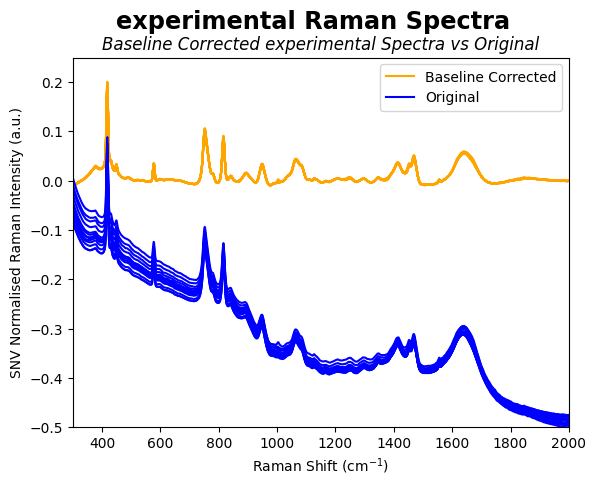

In [164]:
def als(y, lam=1e6, p=0.1, itermax=10):
    L = len(y)
    D = sparse.eye(L, format='csc')
    D = D[1:] - D[:-1]  # numpy.diff( ,2) does not work with sparse matrix. This is a workaround.
    D = D[1:] - D[:-1]
    D = D.T
    w = np.ones(L)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(L, L))
        Z = W + lam * D.dot(D.T)
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

def subtract_als_baseline(scaler_name, spectra_name):
    spectra=scaled_data[f"{scaler_name}_scaled_{spectra_name}_spectra"]
    als_baseline = np.array([als(spectra[:, i]) for i in range(spectra.shape[1])]).T
    return(spectra-als_baseline)

def plot_baseline_corrected_spectra(scaler_name, spectra_name):
    baseline_corrected_spectra = subtract_als_baseline(scaler_name, spectra_name)
    fig, ax = plt.subplots()
    for i in range(baseline_corrected_spectra.shape[1]):
        ax.plot(reference_raman_spectra.index, baseline_corrected_spectra[:,i], color="orange")
    ax.plot([], [], label="Baseline Corrected", color="orange")  #Want one label for the baseline corrected and one label for the original
    for i in range(baseline_corrected_spectra.shape[1]):
        ax.plot(reference_raman_spectra.index, scaled_data[f"{scaler_name}_scaled_{spectra_name}_spectra"][:,i], color="blue")
    ax.plot([], [], label="Original", color="blue")
    ax.set_xlim(300,2000)
    ax.set_ylim(-0.5, 0.25)
    ax.set_xlabel(r'Raman Shift (cm$^{-1})$')
    ax.set_ylabel(f"SNV Normalised Raman Intensity (a.u.)")
    ax.set_title(f"Baseline Corrected {spectra_name} Spectra vs Original",fontdict = {'fontsize': 'large','fontstyle' : "italic",})   
    fig.suptitle(f"{spectra_name} Raman Spectra",
                fontweight="bold",
                fontsize="xx-large"
                )
    ax.legend()

plot_baseline_corrected_spectra("SNV","experimental")

## Identify Peak
- Area of the spectra that changes with concentration, to perform PLS on
- Peak of interest is at 996 - 1015 cm<sup>-1


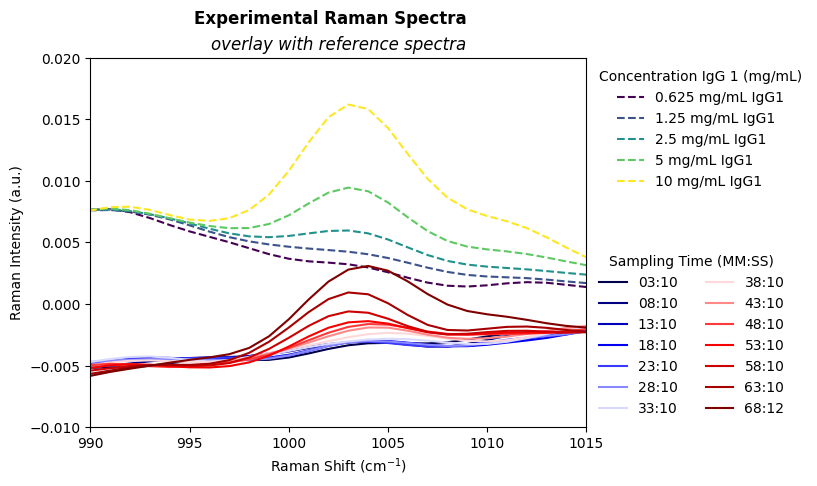

In [182]:
def plot_peak_of_interest(dataframe_1, dataframe_2, xlim, ylim):
    fig, ax = plt.subplots()

    for i, column in enumerate(dataframe_1.columns):
        ax.plot(
            dataframe_1.index,
            (subtract_als_baseline("SNV","reference")).T[i],
            label=column,
            color=purple_colors[i],
            linestyle="--"
        )
    for i, column in enumerate(dataframe_2.columns):
        ax.plot(
            dataframe_2.index,
            (subtract_als_baseline("SNV","experimental")).T[i],
            label=column,
            color=red_colors[i]
        )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(r'Raman Shift (cm$^{-1})$')
    ax.set_ylabel("Raman Intensity (a.u.)")
    ax.set_title(f"overlay with reference spectra",
                fontdict = {'fontsize': 'large','fontstyle' : "italic",}
                )
    fig.suptitle(f"Experimental Raman Spectra",
                fontweight="bold"
                )
    #Generate the legends: 
    handles, labels = ax.get_legend_handles_labels()
    legend_2= ax.legend(handles[len(dataframe_1.columns):], 
                        labels[len(dataframe_1.columns):],
                        title=dataframe_2.columns.name,
                        ncols=2,
                        loc="upper left",
                        bbox_to_anchor=(1, 0.5),
                        frameon=False
                        )
    ax.add_artist(legend_2)
    ax.legend(handles[0:len(dataframe_1.columns)], 
                labels[0:len(dataframe_1.columns)],
                title=dataframe_1.columns.name,
                loc="upper left",
                bbox_to_anchor=(1, 1),
                frameon=False
            )

plot_peak_of_interest(reference_raman_spectra, experimental_raman_spectra, (990,1015), (-0.01,0.02))

## Application of a Common Baseline Level
1. Extract region of the spectra of interest (996 - 1015 cm <sup>-1</sup>)
2. Find the minimum or mean intensity and subtract: 
    - Mean will make the average intensity in the baseline region becomes zero
    - Min will align the entire spectrum such that its lowest point touches zero 

In [204]:
reference_raman_spectra.columns

Index(['0.625 mg/mL IgG1', '1.25 mg/mL IgG1', '2.5 mg/mL IgG1', '5 mg/mL IgG1',
       '10 mg/mL IgG1'],
      dtype='object', name='Concentration IgG 1 (mg/mL)')

In [205]:
def extract_region_of_interest(spectra_name, ramanshift_start, ramanshift_end):
    if spectra_name == "reference":
        column_names = reference_raman_spectra.columns
    elif spectra_name == "experimental":
        column_names = experimental_raman_spectra.columns
    else:
        raise ValueError("Invalid spectra_name. Use 'reference' or 'experimental'.")
    als_corrected_spectra_df = pd.DataFrame(
        data=subtract_als_baseline("SNV",spectra_name), 
        index=wavenumbers,
        columns=reference_raman_spectra.columns
    )
    return(als_corrected_spectra_df.sort_index().loc[ramanshift_start:ramanshift_end])

extract_region_of_interest("reference", 990, 1015)

Concentration IgG 1 (mg/mL),0.625 mg/mL IgG1,1.25 mg/mL IgG1,2.5 mg/mL IgG1,5 mg/mL IgG1,10 mg/mL IgG1
990,0.000924,0.000698,0.000264,0.000254,0.001205
991,0.001015,0.000883,0.000309,0.000133,0.001091
992,0.001058,0.000995,0.000363,0.000087,0.000990
993,0.000986,0.001024,0.000432,0.000125,0.000903
994,0.000810,0.000984,0.000486,0.000191,0.000841
995,0.000630,0.000862,0.000455,0.000224,0.000850
996,0.000544,0.000670,0.000323,0.000217,0.000945
997,0.000563,0.000514,0.000202,0.000215,0.001044
998,0.000621,0.000513,0.000235,0.000274,0.001019
999,0.000655,0.000643,0.000420,0.000388,0.000825


## References for PLS
- An Introduction to Partial Least Squares Regression Randall D. Tobias, SAS Institute Inc., Cary, NC: 
    - Partial least squares (PLS) is a method for constructing predictive models when the factors are many and highly collinear.
    - In principle, MLR can be used with very many factors.
However, if the number of factors gets too large (for
example, greater than the number of observations),
you are likely to get a model that fits the sampled
data perfectly but that will fail to predict new data well.
This phenomenon is called over-fitting
    - There may
be only a few underlying or latent factors that account
for most of the variation in the response. The general
idea of PLS is to try to extract these latent factors,
accounting for as much of the manifest factor variation as possible while modeling the responses well.
    - If the number of extracted factors is greater than or
equal to the rank of the sample factor space, then
PLS is equivalent to MLR.  An important feature of the
method is that usually a great deal fewer factors are
required. The precise number of extracted factors is
usually chosen by some heuristic technique based on
the amount of residual variation. 
    - If no convenient test set is available,
then each observation can be used in turn as a test
set; this is known as cross-validation.
- [Introduction to PLS-DA](https://www.youtube.com/watch?v=cupvyzS0n38&t=855s) on Youtube. Although we are not doing a classification PLS, we are doing a regression analysis, this has good visuals that explain PLS simply. 

- [A study of PLS Methods by Jacob A. Wegelin](https://stat.uw.edu/sites/default/files/files/reports/2000/tr371.pdf)
- [Learn Data article on PLS](https://learndataa.com/2021/04/30/partial-least-squares-pls-w2a-algorithm/) showing the implementation of the PLS-W2A algorithm from in Python using the source code from Scikit-learn docs, and the two associatied Youtubes videos.
- [Learn Data Youtube video](https://www.youtube.com/watch?v=QgJp0otqeGM) on using Scikit Learn PLS to perform Chemometrics on N-IR spectra, to determine the amylose content in rice. The associated Jupyter notebook canbe found [here](https://github.com/learndataa/projects/blob/main/i80_sk77_SL_55__project__Spectroscopy_Chemometrics.ipynb).
**Citation**: [P. Sampaio, A. Soares, A. Castanho, A.S. Almeida, J. Oliveira, C. Brites, Dataset of Near-infrared spectroscopy measurement for amylose determination using PLS algorithms, Volume 15, 2017, Pages 389-396, ISSN 2352-3409](https://doi.org/10.1016/j.dib.2017.09.077)
- [scikit learn Cross Decomposition](https://scikit-learn.org/stable/modules/cross_decomposition.html)
- [scikit learn PCR vs. PLS](https://scikit-learn.org/stable/modules/cross_decomposition.html)



### Cross Validation
- [scikit learn aritcle](https://scikit-learn.org/1.5/modules/cross_validation.html#cross-validation-evaluating-estimator-performance)
- Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set
- However, since we have 5 samples only for reference, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.
- A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

    - A model is trained using k-1 of the folds as training data; we will specify 4
    - the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).
- [scikit learn cross validation predictions](https://scikit-learn.org/1.5/auto_examples/model_selection/plot_cv_predict.html#sphx-glr-auto-examples-model-selection-plot-cv-predict-py)

**Leave One Out cross validation** used for my data set as it is a small trraining set:
- Runs iterations = no of samples 
- Each iteration it leaves one out and tests on that one
- It is goood for small training sets as it maximise the data the model is being trained on before testing. In our casae that means each iteration gets to train on 4 samples
- The only reason not to use it would be that it is computationally expensive - this won't be a problem with 5 samples! 

In [518]:
#Data for PLS:
# x_train=np.array(als_reference_spectra_df.sort_index().loc[990:1015]).T
# x_exp=np.array(als_experimental_spectra_df.sort_index().loc[990:1015]).T
x_train=ref_spectra_region_corr.T
y_train=np.array([float(column.split()[0]) for column in reference_raman_spectra.columns])
x_exp=exp_spectra_region_corr.T


Leave-One-Out cross-validated PLS model performance:
 Average MSE: 0.09
 Standard Deviation: 0.15


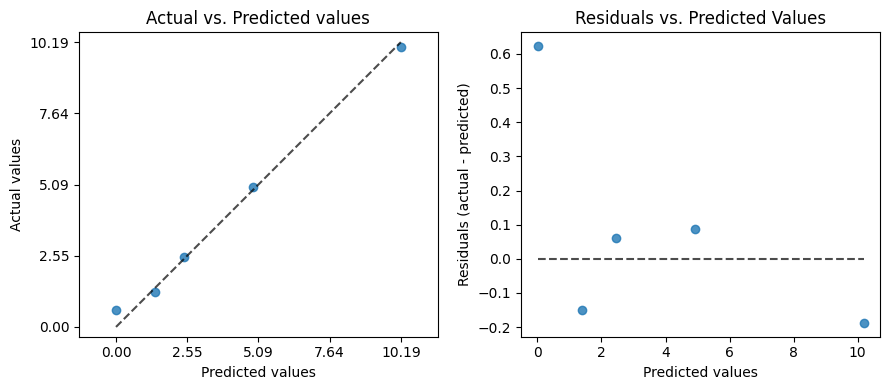

In [519]:
pls2_model=PLSRegression(n_components=2)
pls2_model=pls2_model.fit(x_train, y_train)

# Cross validation because I don't have enough samples for a train/ test split 
score=sklearn.model_selection.cross_val_score(estimator=pls2_model, X=x_train, y=y_train, cv=LeaveOneOut(), scoring=make_scorer(mean_squared_error)) 
print(f"Leave-One-Out cross-validated PLS model performance:\n Average MSE: {score.mean():.2f}\n Standard Deviation: {score.std():.2f}")

y_pred=cross_val_predict(estimator=pls2_model, X=x_train, y=y_train, cv=LeaveOneOut())

fig, axs = plt.subplots(ncols=2, figsize=(9, 4))
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.tight_layout()

Text(0.5, 0.98, 'Model Prediction')

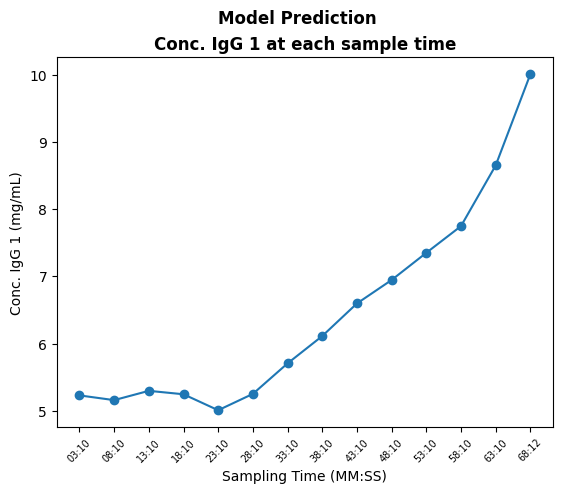

In [520]:
y_pred_exp=pls2_model.predict(x_exp)

fig, ax=plt.subplots()
ax.plot(
    sampling_time_formatted,
    y_pred_exp,
    marker="o"
)
ax.set_xticks(sampling_time_formatted)
ax.set_xticklabels(sampling_time_formatted, rotation=45, 
                   fontdict= {'fontsize': 'x-small',}
                   )
ax.set_xlabel(f"Sampling Time (MM:SS)")
ax.set_ylabel("Conc. IgG 1 (mg/mL)")
ax.set_title("Conc. IgG 1 at each sample time",
             fontdict = {'fontsize': 'large','fontweight' : "bold",}
             )
fig.suptitle(f"Model Prediction",
             fontweight="bold"
             )

**************

# **END**
